In [3]:
import pandas as pd

In [4]:
USdata5 = pd.read_csv("USdata5.csv")
USdata5.columns

Index(['Unnamed: 0', 'eventid', 'iyear', 'imonth', 'iday', 'extended',
       'country', 'region', 'provstate', 'latitude', 'longitude',
       'specificity', 'vicinity', 'crit1', 'crit2', 'crit3', 'doubtterr',
       'alternative', 'multiple', 'success', 'suicide', 'attacktype1',
       'attacktype2', 'targtype1', 'natlty1', 'motive', 'guncertain1',
       'individual', 'nperps', 'nperpcap', 'claimed', 'compclaim', 'weaptype1',
       'weapsubtype1', 'weapsubtype2', 'weapsubtype3', 'nkill', 'nkillus',
       'nkillter', 'nwound', 'nwoundus', 'nwoundte', 'property', 'propextent',
       'propextent_txt', 'propvalue', 'ishostkid', 'nhours', 'ransom',
       'ransomamt', 'ransompaid', 'ransomnote', 'hostkidoutcome', 'nreleased',
       'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'East', 'casualties',
       'casualty_bin', 'USregion', 'Debt_Held_by_the_Public',
       'Intragovernmental_Holdings', 'Total_Public_Debt_Outstanding', 'Year_x',
       'Arms Imports', 'Worldwide Total', 'Sta

In [5]:
#pip install tensorflow keras
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional

In [10]:
#pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 39.7 MB/s eta 0:00:00


In [7]:
df=USdata5

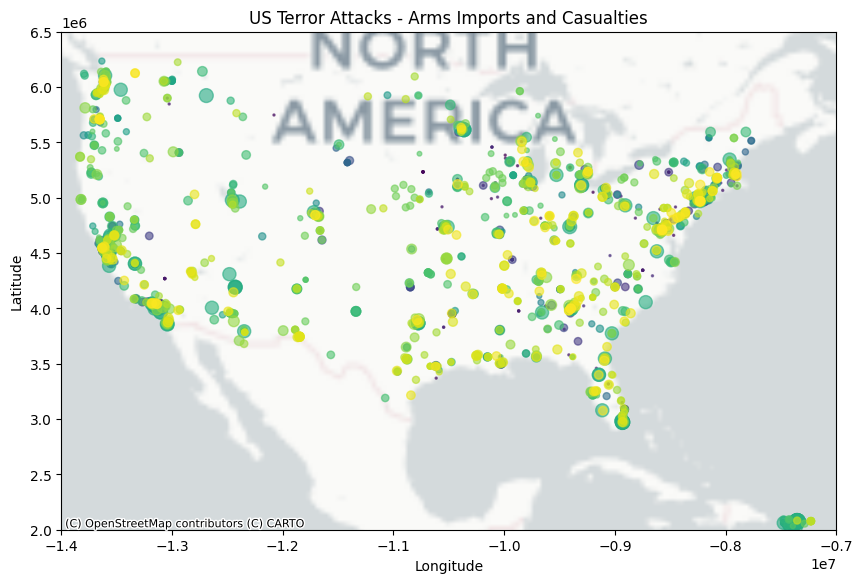

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Assume 'df' is your existing DataFrame
# Ensure 'df' has columns 'longitude', 'latitude', 'Arms Imports', and 'casualties'

# Convert your DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

# Set the coordinate reference system (CRS) to WGS84 (latitude and longitude)
gdf.set_crs(epsg=4326, inplace=True)

# Transform the CRS to web mercator for contextily compatibility
gdf = gdf.to_crs(epsg=3857)

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the points with color based on 'Arms Imports' and size based on 'casualties'
gdf.plot(
    ax=ax,
    markersize=gdf['Arms Imports'] * .05,  # Adjust size as needed
    c=gdf['casualties'],
    cmap='viridis',
    alpha=0.6,
    legend=True
)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Zoom in on the US
ax.set_xlim([-1.4e7, -0.7e7])
ax.set_ylim([2e6, .65e7])

# Set plot title and labels
plt.title('US Terror Attacks - Arms Imports and Casualties')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()



In [12]:

train_df = df[df['iyear'] <= 2015]
test_df = df[df['iyear'] > 2015]

In [13]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

def save_maps(df, output_dir, year, month):
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    gdf.set_crs(epsg=4326, inplace=True)

    gdf = gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))

    gdf.plot(
        ax=ax,
        markersize=gdf['Arms Imports'] * 0.05,  # Adjust size as needed
        c=gdf['casualties'],
        cmap='viridis',
        alpha=0.6,
        legend=True
    )

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    ax.set_xlim([-1.4e7, -0.7e7])
    ax.set_ylim([2e6, .65e7])

    plt.title(f'US Terror Attacks - {year}-{month:02d}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    output_path = os.path.join(output_dir, f'{year}_{month:02d}.png')
    plt.savefig(output_path)
    plt.close()

train_output_dir = 'train_maps'
test_output_dir = 'test_maps'
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)

for year in range(1970, 2016):
    for month in range(1, 13):
        df_subset = train_df[(train_df['iyear'] == year) & (train_df['imonth'] == month)]
        if not df_subset.empty:
            save_maps(df_subset, train_output_dir, year, month)

for year in range(2016, 2022):
    for month in range(1, 13):
        df_subset = test_df[(test_df['iyear'] == year) & (test_df['imonth'] == month)]
        if not df_subset.empty:
            save_maps(df_subset, test_output_dir, year, month)


In [14]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, UpSampling2D, Conv2D, Activation, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def create_image_df(output_dir):
    image_paths = []
    years = []
    months = []

    for file_name in os.listdir(output_dir):
        if file_name.endswith('.png'):
            parts = file_name.split('.')[0].split('_')
            year = int(parts[0])
            month = int(parts[1])
            image_paths.append(os.path.join(output_dir, file_name))
            years.append(year)
            months.append(month)

    return pd.DataFrame({'image_path': image_paths, 'year': years, 'month': months})

train_output_dir = 'train_maps'
test_output_dir = 'test_maps'

train_image_df = create_image_df(train_output_dir)
test_image_df = create_image_df(test_output_dir)

# ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_image_df,
    x_col='image_path',
    y_col=None,
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_image_df,
    x_col='image_path',
    y_col=None,
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    shuffle=True
)


Found 462 validated image filenames.
Found 66 validated image filenames.


**Current Model** 7/30

In [15]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU, UpSampling2D, Conv2D, Activation, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [16]:
def create_image_df(output_dir):
    image_paths = []
    years = []
    months = []

    for file_name in os.listdir(output_dir):
        if file_name.endswith('.png'):
            parts = file_name.split('.')[0].split('_')
            year = int(parts[0])
            month = int(parts[1])
            image_paths.append(os.path.join(output_dir, file_name))
            years.append(year)
            months.append(month)

    return pd.DataFrame({'image_path': image_paths, 'year': years, 'month': months})

train_output_dir = 'train_maps'
test_output_dir = 'test_maps'

train_image_df = create_image_df(train_output_dir)
test_image_df = create_image_df(test_output_dir)

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [17]:
train_generator = train_datagen.flow_from_dataframe(
    train_image_df,
    x_col='image_path',
    y_col=None,
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_image_df,
    x_col='image_path',
    y_col=None,
    target_size=(256, 256),
    batch_size=32,
    class_mode=None,
    shuffle=True
)

Found 462 validated image filenames.
Found 66 validated image filenames.


In [18]:
def build_generator():
    model = Sequential()
    model.add(Dense(128 * 64 * 64, activation="relu", input_dim=100))
    model.add(Reshape((64, 64, 128)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    return model

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(256, 256, 3), padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model

In [20]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

discriminator.trainable = False

valid = discriminator(img)

combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

epochs = 100
batch_size = 32
save_interval = 50

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

In [22]:
for epoch in range(epochs):
    imgs = next(train_generator)
    if imgs.shape[0] != batch_size:
        continue

    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    d_loss_real = discriminator.train_on_batch(imgs, valid)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = combined.train_on_batch(noise, valid)

    if epoch % save_interval == 0:
        print(f"{epoch} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)


        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, :])
                axs[i, j].axis('off')
                cnt += 1
        fig.savefig(f"gan_images_{epoch}.png")
        plt.close()

1/1 [==============================] - 21s 21s/step
0 [D loss: 2.4353289773280267 | D accuracy: 50.0] [G loss: 1.9296824932098389]
1/1 [==============================] - 10s 10s/step


KeyboardInterrupt: 

In [72]:
#pip install tensorflow-gan
import tensorflow

In [80]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.linalg import sqrtm
import numpy as np
import tensorflow as tf

def calculate_fid(real_images, fake_images):
    # Load InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))

    def preprocess_images(images):
        images = (images + 1.0) / 2.0 * 255  # Rescale images from [-1, 1] to [0, 255]
        images = np.array([img_to_array(img) for img in images])
        images = preprocess_input(images)
        return images

    real_images = preprocess_images(real_images)
    fake_images = preprocess_images(fake_images)

    # Get features
    real_features = model.predict(real_images)
    fake_features = model.predict(fake_images)

    # Calculate FID score
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = fake_features.mean(axis=0), np.cov(fake_features, rowvar=False)
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    fid_score = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid_score

# Example usage
fid_score = calculate_fid(real_images, fake_images)
print("FID Score:", fid_score)


1/1 [==============================] - 0s 48ms/step
FID Score: (320.8364575628143-3.3195310975528054e-07j)


In [45]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128,(3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)])

1/1 [==============================] - 0s 25ms/step


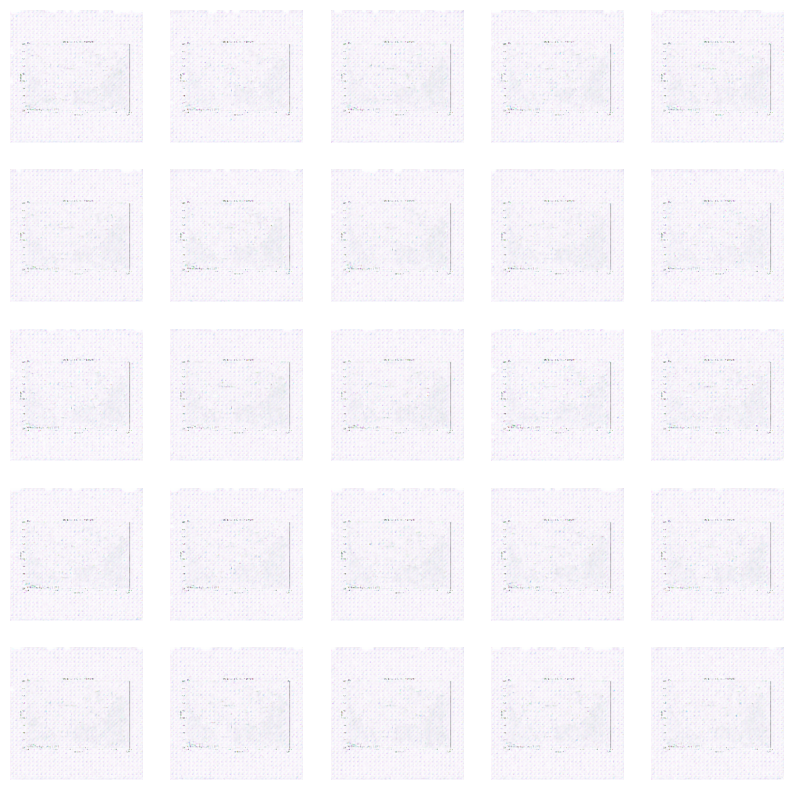

In [81]:
import matplotlib.pyplot as plt
import numpy as np

def show_generated_images(generator, n_images=25, dim=(5, 5), figsize=(10, 10)):
    """
    Function to display a grid of generated images.

    Parameters:
    - generator: The generator model used to create images.
    - n_images: Number of images to generate and display.
    - dim: Dimensions of the grid (rows, columns).
    - figsize: Size of the figure.
    """
    # Generate a batch of images
    noise = np.random.normal(0, 1, (n_images, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images from [-1, 1] to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Plot the generated images
    fig, axs = plt.subplots(dim[0], dim[1], figsize=figsize)
    cnt = 0
    for i in range(dim[0]):
        for j in range(dim[1]):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Example usage
show_generated_images(generator)


In [ ]:
import os
from tqdm import tqdm

# Create a directory to save the images if it doesn't exist
image_dir = "map_images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Function to create and save a map image
def save_map_image(df, date, filepath):
    # Convert your DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

    # Set the coordinate reference system (CRS) to WGS84 (latitude and longitude)
    gdf.set_crs(epsg=4326, inplace=True)

    # Transform the CRS to web mercator for contextily compatibility
    gdf = gdf.to_crs(epsg=3857)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the points with color based on 'Arms Imports' and size based on 'casualties'
    gdf.plot(
        ax=ax,
        markersize=gdf['Arms Imports'] * 1.5,  # Adjust size as needed
        c=gdf['casualties'],
        cmap='viridis',
        alpha=0.6,
        legend=True
    )

    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Zoom in on the US
    ax.set_xlim([-1.5e7, -0.5e7])
    ax.set_ylim([0, 1.2e7])

    # Set plot title and labels
    plt.title(f'US Terror Attacks - {date}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Save the figure
    plt.savefig(filepath, bbox_inches='tight')
    plt.close()

# Iterate through your data, generate and save maps
for date, group in tqdm(df.groupby('iyear')):
    save_map_image(group, date, f"{image_dir}/{date}.png")


100%|██████████| 51/51 [00:41<00:00,  1.22it/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

# Create a DataFrame with image paths and labels
image_paths = []
labels = []

for date, group in df.groupby('iyear'):
    image_paths.append(f"{image_dir}/{date}.png")
    labels.append(label_to_int[group['label_column'].iloc[0]])

# Convert to DataFrame
image_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Split into training and validation sets
train_df, val_df = train_test_split(image_df, test_size=0.2, random_state=42)

# ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),  # Adjust based on your image size
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label',
    target_size=(256, 256),  # Adjust based on your image size
    batch_size=32,
    class_mode='raw'
)

# Define your CNN model (example)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Adjust based on your number of classes
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)


KeyError: 'label_column'

In [ ]:
   for year in range(1970, 2022):
    yearly_data = df[df['iyear'] == year]  # Filter data by year
    gdf_yearly = gpd.GeoDataFrame(
        yearly_data, geometry=gpd.points_from_xy(yearly_data.longitude, yearly_data.latitude))
    gdf_yearly.set_crs(epsg=4326, inplace=True)
    gdf_yearly = gdf_yearly.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_yearly.plot(ax=ax, markersize=5, color='red', alpha=0.5)
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

    plt.title(f'US Terror Attacks - {year}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.savefig(f'us_terror_attacks_{year}.png')
    plt.close()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Assuming USdata2 is your DataFrame and it includes 'iyear', 'imonth', 'longitude', 'latitude', 'eventid', 'Arms Imports'
# Ensure data types are correct
USdata5['iyear'] = USdata5['iyear'].astype(int)
USdata5['imonth'] = USdata5['imonth'].astype(int)

# Create a directory to save the images
output_dir = 'monthly_maps'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plotting function
def plot_monthly_map(year, month, data):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(data['longitude'], data['latitude'],
                          s=data['eventid']*2,
                          c=data['Arms Imports'],
                          cmap='viridis',
                          alpha=0.6,
                          edgecolors='w',
                          linewidth=0.5)
    plt.colorbar(scatter, label='Arms Imports')
    plt.title(f'US Terror Attacks - {year}-{month:02d}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, f'{year}_{month:02d}.png'))
    plt.close()

# Iterate over each month and plot the map
for (year, month), group in USdata5.groupby(['iyear', 'imonth']):
    plot_monthly_map(year, month, group)

print(f"Maps saved to {output_dir}")


Maps saved to monthly_maps


In [ ]:
import os
import numpy as np
import cv2  # OpenCV for image processing
from sklearn.model_selection import train_test_split

# Define the path to the directory where the images are stored
image_dir = 'monthly_maps'

# Define image dimensions (assuming a standard size, e.g., 256x256 pixels)
img_height, img_width = 256, 256

# Initialize lists to store images and labels
images = []
labels = []

# Iterate through the files in the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.png'):
        # Load the image
        img = cv2.imread(os.path.join(image_dir, filename))
        # Resize the image
        img = cv2.resize(img, (img_width, img_height))
        # Normalize the image
        img = img / 255.0
        # Append the image to the list
        images.append(img)

        # Extract the label from the filename (assuming the filename contains the date information)
        year_month = filename.split('.')[0]
        labels.append(year_month)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (422, 256, 256, 3)
Testing data shape: (106, 256, 256, 3)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 128)       0

In [ ]:
# Convert labels to integer encoding
label_to_int = {label: idx for idx, label in enumerate(np.unique(labels))}
int_labels = np.array([label_to_int[label] for label in y_train])

# Train the model
history = model.fit(X_train, int_labels, epochs=20, validation_split=0.2, batch_size=32)

# Save the label encoding dictionary for future use
import pickle
with open('label_to_int.pkl', 'wb') as f:
    pickle.dump(label_to_int, f)


Epoch 1/20
11/11 [==============================] - 12s 308ms/step - loss: 6.6900 - accuracy: 0.0030 - val_loss: 6.3088 - val_accuracy: 0.0000e+00
Epoch 2/20
11/11 [==============================] - 1s 76ms/step - loss: 6.2717 - accuracy: 0.0030 - val_loss: 6.2922 - val_accuracy: 0.0000e+00
Epoch 3/20
11/11 [==============================] - 1s 82ms/step - loss: 6.2575 - accuracy: 0.0059 - val_loss: 6.3473 - val_accuracy: 0.0118
Epoch 4/20
11/11 [==============================] - 1s 77ms/step - loss: 6.2298 - accuracy: 0.0030 - val_loss: 6.4609 - val_accuracy: 0.0000e+00
Epoch 5/20
11/11 [==============================] - 1s 90ms/step - loss: 6.1900 - accuracy: 0.0059 - val_loss: 6.4077 - val_accuracy: 0.0000e+00
Epoch 6/20
11/11 [==============================] - 1s 88ms/step - loss: 6.1702 - accuracy: 0.0000e+00 - val_loss: 6.6349 - val_accuracy: 0.0000e+00
Epoch 7/20
11/11 [==============================] - 1s 90ms/step - loss: 6.1438 - accuracy: 0.0059 - val_loss: 7.1996 - val_accu

In [ ]:
# Convert test labels to integer encoding
int_labels_test = np.array([label_to_int[label] for label in y_test])

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, int_labels_test)
print(f'Test accuracy: {test_acc}')

# Save the trained model
model.save('cnn_model.h5')

# Make predictions (example)
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert predicted integer labels back to original labels
int_to_label = {v: k for k, v in label_to_int.items()}
predicted_labels = [int_to_label[pred] for pred in predicted_labels]

print(predicted_labels[:10])


4/4 [==============================] - 1s 238ms/step - loss: 8.4430 - accuracy: 0.0000e+00
Test accuracy: 0.0


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 0s 26ms/step
['1981_07', '1981_07', '1981_07', '1981_07', '1981_07', '1981_07', '1981_07', '1981_07', '1981_07', '1981_07']


In [ ]:
USdata_sorted = USdata2.sort_values(by=['iyear', 'imonth', 'iday'])

# Define X and y
X = USdata_sorted.drop(columns=['provstate'])
y = USdata_sorted['provstate']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Calculate the split index
split_index = int(len(USdata_sorted) * 0.95)

# Split the data into training and test sets based on the split index
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded[:split_index]
y_test = y_encoded[split_index:]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:


# Reshape the input to be 3D for LSTM [samples, timesteps, features]
# Here, we use timesteps=1 since each row is an independent event
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the enhanced LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(units=128, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=len(np.unique(y_encoded)), activation='softmax'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=128, validation_split=0.2)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


Epoch 1/100
19/19 [==============================] - 26s 184ms/step - loss: 3.8885 - accuracy: 0.3487 - val_loss: 3.8932 - val_accuracy: 0.2318
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 3.1170 - accuracy: 0.4283 - val_loss: 3.6804 - val_accuracy: 0.2115
Epoch 3/100
19/19 [==============================] - 0s 19ms/step - loss: 2.1895 - accuracy: 0.5006 - val_loss: 3.4810 - val_accuracy: 0.2284
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 1.8729 - accuracy: 0.5417 - val_loss: 3.2854 - val_accuracy: 0.2369
Epoch 5/100
19/19 [==============================] - 0s 21ms/step - loss: 1.6890 - accuracy: 0.5904 - val_loss: 3.1460 - val_accuracy: 0.2538
Epoch 6/100
19/19 [==============================] - 0s 19ms/step - loss: 1.5494 - accuracy: 0.6289 - val_loss: 3.0107 - val_accuracy: 0.2504
Epoch 7/100
19/19 [==============================] - 0s 15ms/step - loss: 1.4288 - accuracy: 0.6454 - val_loss: 2.8927 - val_accuracy: 0.2640
Epoc

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Assuming USdata2 is your DataFrame and it includes 'iyear', 'imonth', 'iday', and 'provstate'

# Sort the data by 'iyear', 'imonth', and 'iday'
USdata_sorted = USdata2.sort_values(by=['iyear', 'imonth', 'iday'])

# Define X and y
X = USdata_sorted.drop(columns=['provstate'])
y = USdata_sorted['provstate']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Calculate the split index
split_index = int(len(USdata_sorted) * 0.8)

# Split the data into training and test sets based on the split index
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded[:split_index]
y_test = y_encoded[split_index:]

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the input to be 3D for Conv1D [samples, timesteps, features]
# Here, we use timesteps=1 since each row is an independent event
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, validation_split=0.2)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


NameError: name 'USdata2' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout

# Assuming USdata2 is your DataFrame and it includes 'iyear', 'imonth', 'iday', and 'provstate'

# Sort the data by 'iyear', 'imonth', and 'iday'
USdata_sorted = USdata2.sort_values(by=['iyear', 'imonth', 'iday'])

# Define X and y
X = USdata_sorted.drop(columns=['provstate'])
y = USdata_sorted['provstate']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Calculate the split index
split_index = int(len(USdata_sorted) * 0.8)

# Split the data into training and test sets based on the split index
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y_encoded[:split_index]
y_test = y_encoded[split_index:]

# Combine them for resampling
train_data = pd.concat([X_train, pd.Series(y_train, name='provstate')], axis=1)

# Separate majority and minority classes
majority_class = train_data['provstate'].value_counts().idxmax()
minority_classes = train_data['provstate'].value_counts().index.difference([majority_class])

# Upsample minority classes
upsampled_data = [train_data[train_data['provstate'] == majority_class]]
for minority_class in minority_classes:
    minority_data = train_data[train_data['provstate'] == minority_class]
    upsampled_minority_data = resample(minority_data,
                                       replace=True,  # sample with replacement
                                       n_samples=len(upsampled_data[0]),  # match number in majority class
                                       random_state=123)  # reproducible results
    upsampled_data.append(upsampled_minority_data)

# Combine the upsampled minority class with the majority class
train_data_upsampled = pd.concat(upsampled_data)

# Separate features and target
X_train_upsampled = train_data_upsampled.drop(columns=['provstate'])
y_train_upsampled = train_data_upsampled['provstate']

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_upsampled)
X_test_scaled = scaler.transform(X_test)

# Reshape the input to be 3D for Conv1D [samples, timesteps, features]
# Here, we use timesteps=1 since each row is an independent event
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Define the CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_upsampled, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred = np.argmax(model.predict(X_test_scaled), axis=-1)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division=1)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


Epoch 1/50
709/709 [==============================] - 12s 9ms/step - loss: 2.2510 - accuracy: 0.3838 - val_loss: 13.7241 - val_accuracy: 0.0385
Epoch 2/50
709/709 [==============================] - 7s 10ms/step - loss: 1.0171 - accuracy: 0.6720 - val_loss: 19.8940 - val_accuracy: 0.0385
Epoch 3/50
709/709 [==============================] - 6s 8ms/step - loss: 0.7158 - accuracy: 0.7626 - val_loss: 22.6843 - val_accuracy: 0.0385
Epoch 4/50
709/709 [==============================] - 6s 9ms/step - loss: 0.5879 - accuracy: 0.8032 - val_loss: 25.2652 - val_accuracy: 0.0385
Epoch 5/50
709/709 [==============================] - 6s 8ms/step - loss: 0.4848 - accuracy: 0.8344 - val_loss: 25.8648 - val_accuracy: 0.0385
Epoch 6/50
709/709 [==============================] - 6s 9ms/step - loss: 0.4374 - accuracy: 0.8519 - val_loss: 28.2574 - val_accuracy: 0.0385
Epoch 7/50
709/709 [==============================] - 5s 7ms/step - loss: 0.3757 - accuracy: 0.8700 - val_loss: 30.5527 - val_accuracy: 0.03

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Assuming USdata3 is already loaded
# Filter data
train_data = USdata2[USdata2['iyear'] <= 2016]
test_data = USdata2[USdata2['iyear'] > 2016]

# Features and target
X_train = train_data.drop(columns=['provstate', 'iyear'])
y_train = train_data['provstate']
X_test = test_data.drop(columns=['provstate', 'iyear'])
y_test = test_data['provstate']

# Encode target variable
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Convert target to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(len(le.classes_), activation='softmax')  # Output layer with number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_categorical, epochs=50, batch_size=64, validation_split=0.1)


Epoch 1/50
39/39 [==============================] - 1s 9ms/step - loss: 3.5972 - accuracy: 0.2170 - val_loss: 3.6345 - val_accuracy: 0.1769
Epoch 2/50
39/39 [==============================] - 0s 4ms/step - loss: 2.6323 - accuracy: 0.4613 - val_loss: 3.3118 - val_accuracy: 0.2310
Epoch 3/50
39/39 [==============================] - 0s 4ms/step - loss: 2.0578 - accuracy: 0.5355 - val_loss: 3.0880 - val_accuracy: 0.2852
Epoch 4/50
39/39 [==============================] - 0s 5ms/step - loss: 1.7535 - accuracy: 0.5913 - val_loss: 2.8915 - val_accuracy: 0.3357
Epoch 5/50
39/39 [==============================] - 0s 4ms/step - loss: 1.5313 - accuracy: 0.6221 - val_loss: 2.7109 - val_accuracy: 0.3394
Epoch 6/50
39/39 [==============================] - 0s 4ms/step - loss: 1.3583 - accuracy: 0.6494 - val_loss: 2.5439 - val_accuracy: 0.3538
Epoch 7/50
39/39 [==============================] - 0s 5ms/step - loss: 1.2360 - accuracy: 0.6711 - val_loss: 2.4112 - val_accuracy: 0.3610
Epoch 8/50
39/39 [==

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_categorical)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

11/11 [==============================] - 0s 3ms/step - loss: 4.0156 - accuracy: 0.2000
Test Loss: 4.0156
Test Accuracy: 0.2000


In [ ]:
# Assuming new_data is the new DataFrame for years 2017 onwards
new_data = USdata2[USdata2['iyear'] > 2016]

# Filter and preprocess new data
X_new = new_data.drop(columns=['provstate', 'iyear'])
y_new = new_data['provstate']
X_new_scaled = scaler.transform(X_new)
y_new_encoded = le.transform(y_new)
y_new_categorical = to_categorical(y_new_encoded)

# Incremental training
model.fit(X_new_scaled, y_new_categorical, epochs=50, batch_size=64, validation_split=0.1)


Epoch 1/50
5/5 [==============================] - 0s 31ms/step - loss: 3.8884 - accuracy: 0.2222 - val_loss: 2.7393 - val_accuracy: 0.3235
Epoch 2/50
5/5 [==============================] - 0s 20ms/step - loss: 2.9200 - accuracy: 0.3399 - val_loss: 2.6962 - val_accuracy: 0.4118
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 2.3198 - accuracy: 0.4346 - val_loss: 2.5595 - val_accuracy: 0.5000
Epoch 4/50
5/5 [==============================] - 0s 21ms/step - loss: 1.9731 - accuracy: 0.4575 - val_loss: 2.3253 - val_accuracy: 0.5294
Epoch 5/50
5/5 [==============================] - 0s 18ms/step - loss: 1.7204 - accuracy: 0.4967 - val_loss: 2.2502 - val_accuracy: 0.4706
Epoch 6/50
5/5 [==============================] - 0s 19ms/step - loss: 1.5347 - accuracy: 0.5327 - val_loss: 2.2402 - val_accuracy: 0.4118
Epoch 7/50
5/5 [==============================] - 0s 18ms/step - loss: 1.4020 - accuracy: 0.5458 - val_loss: 2.2617 - val_accuracy: 0.3529
Epoch 8/50
5/5 [===========

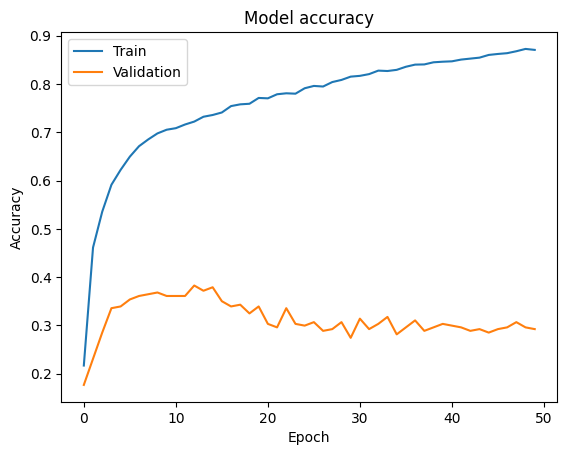

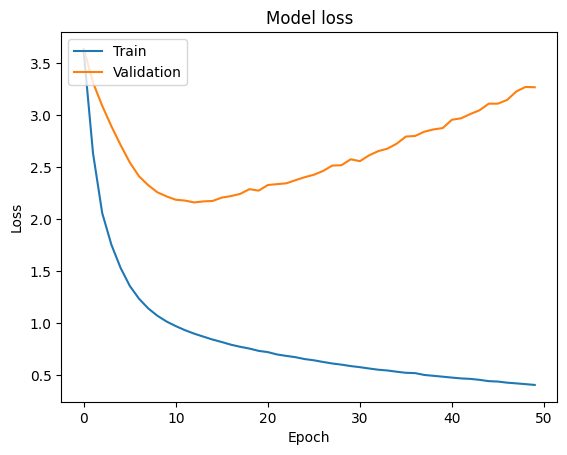

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [ ]:
from sklearn.utils import resample

# Combine features and target for upsampling
train_data = train_data.copy()
train_data['provstate'] = y_train

# Separate majority and minority classes
majority_class = train_data[train_data['provstate'] == 'majority_class']
minority_classes = train_data[train_data['provstate'] != 'majority_class']

# Upsample minority classes
upsampled_minority_classes = resample(minority_classes,
                                      replace=True,
                                      n_samples=len(majority_class),
                                      random_state=42)

# Combine majority class with upsampled minority classes
upsampled_train_data = pd.concat([majority_class, upsampled_minority_classes])

# Separate features and target again
X_train_upsampled = upsampled_train_data.drop(columns=['provstate', 'iyear'])
y_train_upsampled = upsampled_train_data['provstate']

# Encode target variable
y_train_upsampled_encoded = le.transform(y_train_upsampled)

# Scale features
X_train_upsampled_scaled = scaler.transform(X_train_upsampled)

# Convert target to one-hot encoding
y_train_upsampled_categorical = to_categorical(y_train_upsampled_encoded)


ValueError: Found array with 0 sample(s) (shape=(0, 55)) while a minimum of 1 is required by StandardScaler.

In [ ]:
# Check the number of samples in each class
print(f"Majority class samples: {len(majority_class)}")
print(f"Minority class samples: {len(minority_classes)}")


Majority class samples: 0
Minority class samples: 2770


In [ ]:
from sklearn.utils import resample

# Combine features and target for upsampling
train_data = train_data.copy()
train_data['provstate'] = y_train

# Separate classes and upsample each class to the same size
classes = train_data['provstate'].unique()
upsampled_data_list = []

for cls in classes:
    class_data = train_data[train_data['provstate'] == cls]
    upsampled_class_data = resample(class_data,
                                    replace=True,
                                    n_samples=max(len(train_data[train_data['provstate'] == c]) for c in classes),
                                    random_state=42)
    upsampled_data_list.append(upsampled_class_data)

# Combine all upsampled data
upsampled_train_data = pd.concat(upsampled_data_list)

# Separate features and target again
X_train_upsampled = upsampled_train_data.drop(columns=['provstate', 'iyear'])
y_train_upsampled = upsampled_train_data['provstate']

# Encode target variable
y_train_upsampled_encoded = le.transform(y_train_upsampled)

# Scale features
X_train_upsampled_scaled = scaler.fit_transform(X_train_upsampled)

# Convert target to one-hot encoding
y_train_upsampled_categorical = to_categorical(y_train_upsampled_encoded)


In [ ]:
# Define and compile the model again if needed
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_upsampled_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with balanced data
history_upsampled = model.fit(X_train_upsampled_scaled, y_train_upsampled_categorical,
                              epochs=120, batch_size=32, validation_split=0.05)


Epoch 1/120
907/907 [==============================] - 5s 4ms/step - loss: 1.3444 - accuracy: 0.6269 - val_loss: 13.0378 - val_accuracy: 0.2312
Epoch 2/120
907/907 [==============================] - 3s 4ms/step - loss: 0.4572 - accuracy: 0.8648 - val_loss: 14.8453 - val_accuracy: 0.2312
Epoch 3/120
907/907 [==============================] - 4s 4ms/step - loss: 0.2635 - accuracy: 0.9260 - val_loss: 16.6538 - val_accuracy: 0.2312
Epoch 4/120
907/907 [==============================] - 3s 3ms/step - loss: 0.1740 - accuracy: 0.9523 - val_loss: 18.0501 - val_accuracy: 0.2312
Epoch 5/120
907/907 [==============================] - 3s 3ms/step - loss: 0.1267 - accuracy: 0.9637 - val_loss: 19.3708 - val_accuracy: 0.2312
Epoch 6/120
907/907 [==============================] - 3s 4ms/step - loss: 0.0955 - accuracy: 0.9725 - val_loss: 19.9457 - val_accuracy: 0.2312
Epoch 7/120
907/907 [==============================] - 4s 4ms/step - loss: 0.0779 - accuracy: 0.9783 - val_loss: 20.3835 - val_accuracy:

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_categorical)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

11/11 [==============================] - 0s 5ms/step - loss: 12.4836 - accuracy: 0.1471
Test Loss: 12.4836
Test Accuracy: 0.1471


In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the model with dropout for regularization
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_upsampled_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
history_upsampled = model.fit(X_train_upsampled_scaled, y_train_upsampled_categorical,
                              epochs=120, batch_size=64, validation_split=0.05,
                              callbacks=[early_stopping])


Epoch 1/120
454/454 [==============================] - 5s 6ms/step - loss: 3.0832 - accuracy: 0.1885 - val_loss: 9.4524 - val_accuracy: 0.0000e+00
Epoch 2/120
454/454 [==============================] - 3s 6ms/step - loss: 1.9632 - accuracy: 0.3679 - val_loss: 12.5211 - val_accuracy: 0.0000e+00
Epoch 3/120
454/454 [==============================] - 2s 5ms/step - loss: 1.6580 - accuracy: 0.4425 - val_loss: 14.1459 - val_accuracy: 0.0930
Epoch 4/120
454/454 [==============================] - 2s 5ms/step - loss: 1.4974 - accuracy: 0.4884 - val_loss: 15.8637 - val_accuracy: 0.1401


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_test_pred = model.predict(X_test_scaled)
y_test_pred_classes = y_test_pred.argmax(axis=-1)
print(classification_report(y_test_encoded, y_test_pred_classes))
print(confusion_matrix(y_test_encoded, y_test_pred_classes))

11/11 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         3
           3       0.17      0.17      0.17         6
           4       0.67      0.14      0.23        43
           5       0.04      0.25      0.07         4
           6       0.00      0.00      0.00         3
           7       1.00      0.88      0.93         8
           8       0.00      0.00      0.00         5
           9       0.00      0.00      0.00        23
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00         1
          12       0.00      0.00      0.00         1
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         3
          15       0.25      0.33      0.29         6
          16       0.20     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import pandas as pd

# Create a DataFrame with image paths and labels
image_paths = []
labels = []

# Assuming you have some function or way to label your data
for date, group in df.groupby('iyear'):
    image_paths.append(f"{image_dir}/{date}.png")
    labels.append(group[['latitude', 'longitude']].values)  # Use locations as labels

# Convert to DataFrame
image_df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

# Split into training and validation sets
train_df, val_df = train_test_split(image_df, test_size=0.2, random_state=42)

# ImageDataGenerator for loading images
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

def custom_data_generator(df, batch_size, target_size):
    datagen = ImageDataGenerator(rescale=1./255)
    gen = datagen.flow_from_dataframe(
        df,
        x_col='image_path',
        y_col=None,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )

    while True:
        X = gen.next()
        y = df.loc[gen.index_array, 'label'].values
        yield X, y

train_generator = custom_data_generator(train_df, batch_size=32, target_size=(256, 256))
val_generator = custom_data_generator(val_df, batch_size=32, target_size=(256, 256))


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)  # Predicting latitude and longitude
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_df) // 32,
    validation_steps=len(val_df) // 32
)


Found 40 validated image filenames.


KeyError: '[3, 12, 13, 17, 24, 30, 31, 32] not in index'

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)  # Predicting latitude and longitude
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_df) // 32,
    validation_steps=len(val_df) // 32
)


StopIteration: 

In [ ]:
import numpy as np

# Predict future locations
def predict_future_locations(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    return prediction[0]

# Example usage
future_image_path = 'path_to_future_map.png'  # Replace with the path to the future map image
predicted_locations = predict_future_locations(model, future_image_path)
print(f'Predicted locations: {predicted_locations}')


Put in a sequence not an average. predict for next month.

In [ ]:
import matplotlib.pyplot as plt

# Plot the predicted locations on a map
def plot_predictions(predictions, title="Predicted Future Locations"):
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the predicted points
    for loc in predictions:
        plt.scatter(loc[1], loc[0], color='red', s=100)  # Assuming loc[0] is latitude and loc[1] is longitude

    # Add a basemap
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

    # Zoom in on the US
    ax.set_xlim([-1.5e7, -0.5e7])
    ax.set_ylim([0, 1.2e7])

    # Set plot title and labels
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.show()

# Example usage
plot_predictions([predicted_locations])
